## <center> Обучение без учителя: кластеризация

В этом задании мы разберемся как работают методы кластеризации данных.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. 


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [2]:
X_train = np.loadtxt("samsung_train.txt")
y_train = np.loadtxt("samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("samsung_test.txt")
y_test = np.loadtxt("samsung_test_labels.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

In [4]:
X_train.shape

(7352, 561)

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [5]:
X = np.vstack([X_train,X_test])
y = np.hstack([y_train,y_test])

In [6]:
X

array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
         0.17994061, -0.05862692],
       [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
         0.18028889, -0.05431672],
       [ 0.27965306, -0.01946716, -0.11346169, ..., -0.84893347,
         0.18063731, -0.04911782],
       ...,
       [ 0.34996609,  0.03007744, -0.11578796, ..., -0.65535684,
         0.27447878,  0.18118355],
       [ 0.23759383,  0.01846687, -0.09649893, ..., -0.65971859,
         0.26478161,  0.18756291],
       [ 0.15362719, -0.01843651, -0.13701846, ..., -0.66008023,
         0.26393619,  0.1881034 ]])

Определим число уникальных значений меток целевого класса.

In [7]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [8]:
n_classes = np.unique(y).size
n_classes

6

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию


Отмасштабируем выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
X_scaled

array([[ 2.10533854e-01, -6.87026385e-02, -4.52194533e-01, ...,
        -6.74432366e-01,  3.82007658e-01, -1.61505480e-02],
       [ 6.02084832e-02,  3.59023537e-02, -2.75221885e-01, ...,
        -6.81359801e-01,  3.83147865e-01, -1.20627169e-04],
       [ 7.84597052e-02, -4.64269585e-02, -8.55480582e-02, ...,
        -6.89470939e-01,  3.84288531e-01,  1.92144041e-02],
       ...,
       [ 1.11821625e+00,  1.28805864e+00, -1.29414692e-01, ...,
        -3.10750224e-01,  6.91509049e-01,  8.75719123e-01],
       [-5.43492722e-01,  9.75327452e-01,  2.34319837e-01, ...,
        -3.19283719e-01,  6.59762215e-01,  8.99444350e-01],
       [-1.78515253e+00, -1.86663622e-02, -5.29759691e-01, ...,
        -3.19991245e-01,  6.56994458e-01,  9.01454465e-01]])

Сделаем кластеризацию данных методом `KMeans`. В данном случае известно, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [11]:
kmeans = KMeans(n_clusters=6, n_init=100, random_state=123)
kmeans.fit(X)
cluster_labels = kmeans.labels_

Посмотрим на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [12]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,150,0,699,0,873,0,1722
подъем вверх по лестнице,82,0,1165,0,297,0,1544
спуск по лестнице,455,0,186,0,765,0,1406
сидение,0,1253,3,49,0,472,1777
стояние,0,1232,0,0,0,674,1906
лежание,0,0,12,1761,0,171,1944
все,687,2485,2065,1810,1935,1317,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 1:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>


In [13]:
activities = [array[0:-1] for array in tab.values]

act_lbls = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']

act_tab = {activity: clusters for activity, clusters in zip(act_lbls, activities)}
act_tab

{'все': array([ 687, 2485, 2065, 1810, 1935, 1317]),
 'лежание': array([   0,    0,   12, 1761,    0,  171]),
 'подъем вверх по лестнице': array([  82,    0, 1165,    0,  297,    0]),
 'сидение': array([   0, 1253,    3,   49,    0,  472]),
 'спуск по лестнице': array([455,   0, 186,   0, 765,   0]),
 'стояние': array([   0, 1232,    0,    0,    0,  674]),
 'ходьба': array([150,   0, 699,   0, 873,   0])}

In [14]:
act_tab = {activity: (max(clusters) / sum(clusters)) for activity, clusters in zip(act_lbls, activities)}
act_tab

{'все': 0.2412855617050199,
 'лежание': 0.9058641975308642,
 'подъем вверх по лестнице': 0.7545336787564767,
 'сидение': 0.7051209904333146,
 'спуск по лестнице': 0.5440967283072546,
 'стояние': 0.646379853095488,
 'ходьба': 0.5069686411149826}

In [15]:
sorted(act_tab, key=lambda x: x[1])

['лежание',
 'сидение',
 'ходьба',
 'подъем вверх по лестнице',
 'спуск по лестнице',
 'все',
 'стояние']

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте критерии инерции и силуэта, рассмотренные на практикуме, чтобы определить оптимальное количество кластеров (параметры алгоритма и данные используем те же, что раньше, изменяем только `n_clusters`)

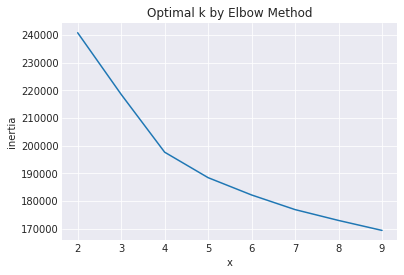

[0.48107627299425504, 0.3242293360389572, 0.1868211411199481, 0.16481206108454222, 0.13287861322748337, 0.11877778513620839, 0.10217296677388678, 0.10974452961732574]


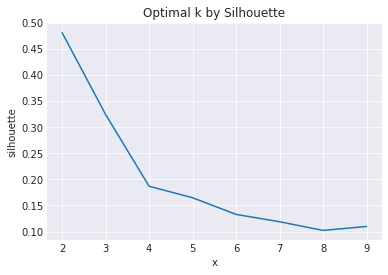

In [17]:
from sklearn.metrics import silhouette_score

inertia = []
silhouette = []
k = range(2, 10)
for k_i in k:
    km = KMeans(n_clusters=k_i)
    km.fit(X)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(X, km.labels_))
    
plt.plot(k, inertia)
plt.xlabel('x')
plt.ylabel('inertia')
plt.title('Optimal k by Elbow Method')
plt.show()

print(silhouette)

plt.plot(k, silhouette)
plt.xlabel('x')
plt.ylabel('silhouette')
plt.title('Optimal k by Silhouette')
plt.show()

Попробуем еще один метод кластеризации, агломеративную кластеризацию.

In [18]:
ag = AgglomerativeClustering(n_clusters=n_classes, linkage='ward').fit(X)

In [19]:
km = KMeans(n_clusters=n_classes, n_init=100, random_state=123).fit(X)

Посчитайте Adjusted Rand Index для разбиений ag и km, где n_classes = подобранное  оптимальное количество кластеров в предыдущем задании.

In [20]:
from sklearn.metrics import adjusted_rand_score

print(adjusted_rand_score(ag.labels_, y))

print(adjusted_rand_score(km.labels_, y))

0.49090734475031733
0.4609885711698349


**Вопрос 2:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
    - True
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
    - False
- В случае случайного разбиения на кластеры ARI будет близок к нулю
    -  True

## ДЗ БОНУС 

Попробуйте метод кластеризации DBSCAN c параметрами по умолчанию. Посчитайте для него ARI.

In [21]:
from sklearn.cluster import DBSCAN

ds = DBSCAN().fit(X)

print(ds.labels_)
print(adjusted_rand_score(ds.labels_, y))

[-1 -1 -1 ... -1 -1 -1]
0.0


Подберите оптимальные параметры min_samples и eps с помощью эвристики. Описание эвристики можно посмотреть здесь https://habr.com/ru/post/322034/.
Запустите DBSCAN еще раз и посмотрите как изменился ARI.

In [22]:
y

array([5, 5, 5, ..., 2, 2, 2])

In [23]:
points = range(4, 7)
e = range(1, 10)

scores = {}

for points_i in points:
    for e_i in e:
        ds = DBSCAN(eps=e_i, min_samples=points_i).fit(X)
        score = adjusted_rand_score(ds.labels_, y)
        print(f'points: {points_i}; epsilon: {e_i}; score: {score}')
        scores[f'{points_i} {e_i}'] = score

points: 4; epsilon: 1; score: 0.0
points: 4; epsilon: 2; score: 0.0
points: 4; epsilon: 3; score: 0.0903478091351429
points: 4; epsilon: 4; score: 0.3173282496255651
points: 4; epsilon: 5; score: 0.0013043299957547407
points: 4; epsilon: 6; score: 0.0002896923832129439
points: 4; epsilon: 7; score: 3.5972226251369725e-05
points: 4; epsilon: 8; score: 3.0172748775200025e-05
points: 4; epsilon: 9; score: 1.5046318408637885e-05
points: 5; epsilon: 1; score: 0.0
points: 5; epsilon: 2; score: 0.0
points: 5; epsilon: 3; score: 0.08071469757459372
points: 5; epsilon: 4; score: 0.31901935878705945
points: 5; epsilon: 5; score: 0.001379996123745508
points: 5; epsilon: 6; score: 0.0003153633484691635
points: 5; epsilon: 7; score: 2.6637699755259304e-05
points: 5; epsilon: 8; score: 3.0172748775200025e-05
points: 5; epsilon: 9; score: 1.5046318408637885e-05
points: 6; epsilon: 1; score: 0.0
points: 6; epsilon: 2; score: 0.0
points: 6; epsilon: 3; score: 0.07283100866257639
points: 6; epsilon: 4; 